## Lección 1: Introducción al aprendizaje de máquinas Clusterización

### Objetivos Notebook Introducción al aprendizaje de máquinas Clusterización 

1. Implementar el cluster jerárquico para algunas clases de activos. 
2. Usar el algoritmo de Hierarchical Risk Parity para encontrar un portafolio óptimo.

### Hierarchical Risk Parity. 

El algoritmo de Hierarchical Risk Parity consta de tres etapas: 

1. Tree Clustering. 
2. Quasi-Diagonalización o serialización de la matriz. 
3. Bisección recursiva.

Explicación: 

1. Tree Clustering

En los algoritmos de clustering generales, no existe una relación definida entre los clusters. Bajo hierarchical clustering se crea una estructura jerárquica de Clusters. Esta estructura jerárquica se puede crear de forma aglomerativa o de forma divisoria: 

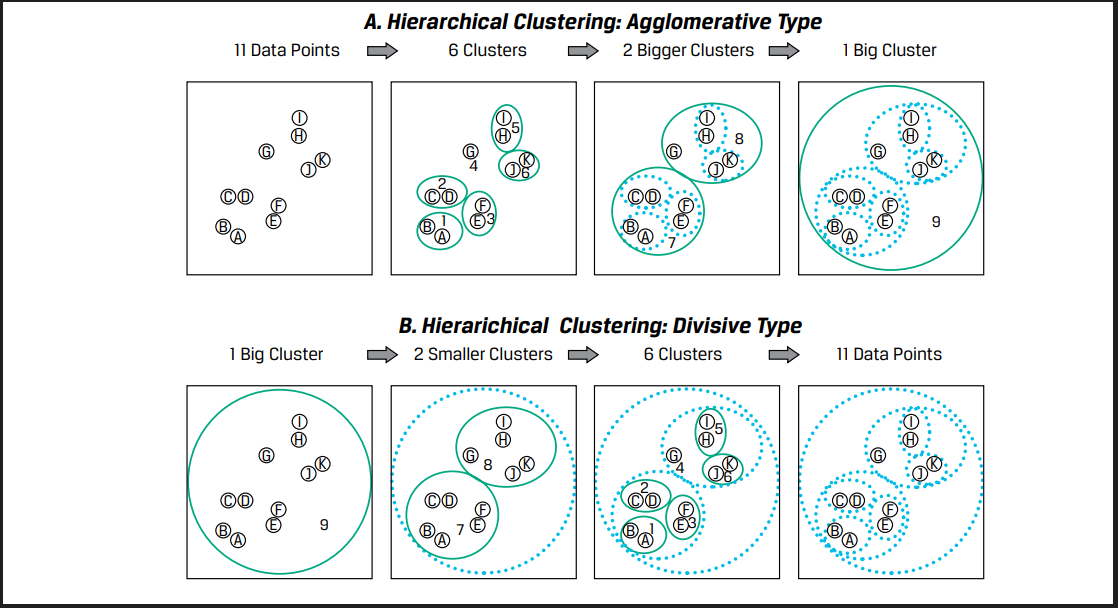

Tomado de: CFA (2024): Quantiative Methods L2V1.  

En el caso particular del algoritmo de hierarchical risk parity se hace con un algoritmo divisorio.

Para determinar que tanto se parecen los clusters, se usan métricas como el máximo, mínimo o promedio de la distancia entre cada pareja de puntos de cada cluster. 


* Los arcos son las líneas hortizontales 
* Las dendritas son las líneas verticales
* La longitud de cada dendrita representa la distancia entre dos clusters. Dendritos mas cortos implican una menor distancia (y mayor similitud) entre los clusters.  
* El orden en el que aparecen las leyendas no acaba necesariamente siendo importante parar evaluar la similitud de las clases de activos.

En nuestro caso nos remitimos a al versión ya implementada en la librería de Scipy Cluster Hierarchy.

In [190]:
import os 
import numpy as np
import pandas as pd
from librerias.finance_operators import calculateLogReturns
from librerias.Technical_Indicators import *
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from librerias.Backtest import *
from librerias.graphs import heatmap
import seaborn as sns

2. Quasi-Diagonalización - Serialización de la matriz 

Aunque en el paper original esta etapa consistía en una quasi-diagonalización de la matriz esto se puede simplicar, para el caso específico del algoritmo de HRP como una serialización de la matriz. Es decir ordenar las columnas de la matriz con base al dendograma obtenido. En este caso por practicidad conservaremos la programación que tiene la quasi diagonalización de la matriz. 


In [191]:
def get_quasi_diag(link):
    
    # sort clustered items by distance    
    link = link.astype(int)
    
    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]]) 
    
    # the total num of items is the third item of the last list
    num_items = link[-1, 3]
    
    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:
        # assign sort_ix index with 24 x 24
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # odd numers as index
        df0 = sort_ix[sort_ix >= num_items] # find clusters
        
        # df0 contain even index and cluster index
        i = df0.index
        j = df0.values - num_items # 
        sort_ix[i] = link[j,0] # item 1
        df0  = pd.Series(link[j, 1], index=i+1)
        sort_ix = pd.concat([sort_ix,df0], axis = 0)
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    
    return sort_ix.tolist()

3. Bisección recursiva

La última etapa del algoritmo consiste en generar de los activos con base en el siguiente algoritmo: 

1. Incialización: 
a. Configura una lista de elementos, llamada 𝐿, donde cada elemento 𝐿₀ es un conjunto que contiene los elementos individuales del 1 al 𝑁.
b. Asigna un peso unitario ($𝑤_{𝑛}=1$) a cada elemento.

2. Verificar Detención: 

1. Si cada subconjunto ($L_{i} \in L$) tiene un solo elemento ($𝐿_{𝑖} = 1 \forall i \in L$) detener el algoritmo.

3. Bisección: 

1. Para cada subconjunto ($L_{i} \in L$) que tiene más de un elemento- 

a. Dividir 𝐿𝑖 en dos subconjuntos, preservando su orden original. 

b. Computa una varianza para cada subconjunto, empleando la siguiente formula $𝑉_{i} ̃^𝑗 = w ̃ _{i}𝑉_{𝑖} w ̃_{i}$, donde los pesos 𝑤 ̃ se obtienen solucionando el problema de Inverse Variance Portfolio. 

c. Ajusta los pesos de los elementos en el primer subconjunto multiplicándolos por el siguiente factor $𝛼_𝑖=1−( 𝑉 ̃𝑖^1)/(𝑉 ̃𝑖^1 +𝑉 ̃𝑖^2  )$. 

d. Ajusta los pesos de los elementos en el segundo subconjunto multiplicándolos por $(1 − 𝛼_𝑖)$


In [192]:
def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice
    # calculate the inversev-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var

def get_rec_bipart(cov, sort_ix):
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)
    
    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        """
        [[ 0, 3, 4], [6, 2 ,1, 5]]
        [[0], [3, 4], [6, 2], [1, 5]]
        [[3], [4], [6], [2], [1], [5]]
        []
        
        """
        print([])
        c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        
        print(c_items)
        # now it has 2
        for i in range(0, len(c_items), 2):
            
            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2
            
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            
            alpha = 1 - c_var0/(c_var0+c_var1)
            
            print(c_var0, c_var1)
            
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha

        print(w)
    return w

### Desarrollo ejemplo de clase.

Importar las clases de activos del dendograma

In [193]:
### Importamos el índice de los activos. 
df_assets_classes = pd.read_csv('datos\\'+'activos_dendograma.csv', encoding='utf-8', sep = ';')
df_assets_classes = df_assets_classes.set_index('id')
df_assets_classes = calculateLogReturns(df_assets_classes)

### Renombramos los Tickers para facilitar la lectura
diccionario_tickers = {'G0QA_TRR_INDEX_VAL_LOC': 'Tes. 0-1', 
                       'GVQ0_TRR_INDEX_VAL_LOC': 'Tes. 1-5', 
                       'GVQI_TRR_INDEX_VAL_LOC': 'TIPS 1-5', 
                       'CV10_TRR_INDEX_VAL_LOC': 'Corp 1-5',
                       'GS1V_TRR_INDEX_VAL_LOC': 'SSA', 
                       'M0A0_TRR_INDEX_VAL_LOC': 'MBS'}
 
                       #'SPX_INDEX': 'Equity'
                       
df_assets_classes = df_assets_classes.rename(columns = diccionario_tickers)
df_assets_classes = df_assets_classes

### Let's get the daily returs of the asset classes.
df_assets_classes.index = pd.to_datetime(df_assets_classes.index)
df_assets_classes = df_assets_classes
df_assets_classes = df_assets_classes.drop(columns = ['C01A_TRR_INDEX_VAL_LOC', 'SPX_INDEX', 'G6QI_TRR_INDEX_VAL_LOC', 'G6O2_TRR_INDEX_VAL_LOC'])
df_assets_classes

C:\Users\jcamargo\AppData\Local\Temp\ipykernel_6888\2888667057.py:20: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_assets_classes.index = pd.to_datetime(df_assets_classes.index)


,Tes. 0-1,Tes. 1-5,TIPS 1-5,Corp 1-5,SSA,MBS
id,,,,,,
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,-0.000040,-0.001118,-0.001911,-0.001295,-0.001087,-0.001705
2006-02-02,0.000113,-0.000023,-0.000893,0.000161,0.000106,0.000202
2006-02-03,0.000142,0.000231,0.001004,0.000173,0.000064,0.000713
2006-02-06,0.000187,-0.000156,0.000095,-0.000008,-0.000120,0.000301
...,...,...,...,...,...,...
2023-12-14,0.000242,0.002097,0.004811,0.003303,0.003633,0.005817
2023-12-15,0.000251,-0.000915,-0.001193,-0.000974,-0.000915,-0.002875
2023-12-18,0.000182,-0.000391,-0.000495,-0.000299,-0.000383,-0.002225


Obtenemos la matriz de correlaciones.

In [194]:
correlation_matrix = df_assets_classes.corr()
correlation_matrix

,Tes. 0-1,Tes. 1-5,TIPS 1-5,Corp 1-5,SSA,MBS
Tes. 0-1,1.000000,0.633364,0.384323,0.405347,0.625509,0.374453
Tes. 1-5,0.633364,1.000000,0.662850,0.781974,0.972968,0.768063
TIPS 1-5,0.384323,0.662850,1.000000,0.658366,0.660166,0.582942
Corp 1-5,0.405347,0.781974,0.658366,1.000000,0.783886,0.697253
SSA,0.625509,0.972968,0.660166,0.783886,1.000000,0.744427
MBS,0.374453,0.768063,0.582942,0.697253,0.744427,1.000000


Obtenemos la matriz de covarianzas

In [195]:
cov = df_assets_classes.cov()
cov = cov*252

Exportamos la matriz de correlaciones en puntos básicos.

In [196]:
cov_bp = cov.copy()

Imprimimos las volatilidades anualizadas

In [197]:
annualized_volatilities = np.sqrt(np.diag(cov))
annualized_volatilities = pd.Series(annualized_volatilities, index = cov.index)
# Las multiplicamos por 100 para que queden en puntos porcentuales
annualized_volatilities*100

Tes. 0-1    0.297109
Tes. 1-5    2.089936
TIPS 1-5    2.713941
Corp 1-5    2.441295
SSA         2.008491
MBS         3.780318
dtype: float64

Obtenemos la matriz de linqueado.

### 1. Tree Clustering

In [198]:
linkage_matrix = linkage(correlation_matrix, method='single')

Graficamos el dendograma

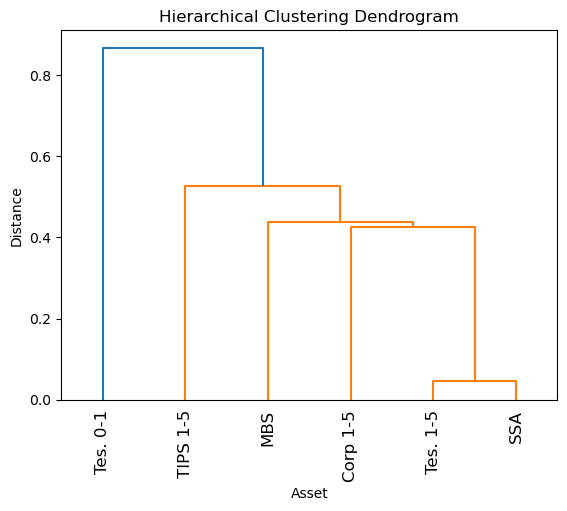

In [199]:
dendro = dendrogram(linkage_matrix, labels=[*diccionario_tickers.values()])
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Asset')
plt.xticks(rotation=90)
plt.ylabel('Distance')
plt.show()

### 2. Quasidiagonalización. 

In [200]:
def get_quasi_diag(link):
    
    # sort clustered items by distance    
    link = link.astype(int)
    
    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]]) 
    
    # the total num of items is the third item of the last list
    num_items = link[-1, 3]
    
    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:
        # assign sort_ix index with 24 x 24
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # odd numers as index
        df0 = sort_ix[sort_ix >= num_items] # find clusters
        
        # df0 contain even index and cluster index
        i = df0.index
        j = df0.values - num_items # 
        
        sort_ix[i] = link[j,0] # item 1
        
        df0  = pd.Series(link[j, 1], index=i+1)
        
        sort_ix = pd.concat([sort_ix,df0], axis = 0)
        
        sort_ix = sort_ix.sort_index()

        sort_ix.index = range(sort_ix.shape[0])
        
    return sort_ix.tolist()

Procedemos con la segunda etapa del algoritmo que consiste en la quasi-diagonalización de la matriz de correlacione, es decir buscar que los valores mas altos de las correlacionnes caigan sobre la diagonal. Esta etapa básicamente ordenas las columnas de la matriz de tal manera que los activos que mas se parezcan entre ellos queden situados más cerca. Nos damos cuenta de que el orden resultante es el siguiente:  

In [201]:
# Step 1. 
linkage_matrix = linkage_matrix.astype(int)
linkage_matrix

array([[1, 4, 0, 2],
       [3, 6, 0, 3],
       [5, 7, 0, 4],
       [2, 8, 0, 5],
       [0, 9, 0, 6]])

In [202]:
# Step 2. 
sort_ix = pd.Series([linkage_matrix[-1,0], linkage_matrix[-1,1]]) 
sort_ix


0    0
1    9
dtype: int32

In [203]:
sort_ix = get_quasi_diag(linkage_matrix)
sort_ix

[0, 2, 5, 3, 1, 4]

Procedemos con la segunda etapa del algoritmo que consiste en la Quasidiagonalización de la matriz. Esto se puede llevar a cabo con la función que está programada en el paper de López de Prado, o bien directamente tomando en cuenta el orden que generamos en el dendograma.

In [204]:
initial_order = [*diccionario_tickers.values()]
sorted_lst = [df_assets_classes.columns[i] for i in sort_ix]
assets_df = pd.DataFrame(sorted_lst, initial_order).reset_index()
assets_df = assets_df.rename(columns = {'index':'Initial Order', 0:'New Order'})
##################################################################################################
### NO OLVIDAR MEJORAR EL FORMATO DE LA TABLA DE CARA A PASARLA A LIMPIO EN LA PRESENTACIÓN ###
##################################################################################################
assets_df

,Initial Order,New Order
0,Tes. 0-1,Tes. 0-1
1,Tes. 1-5,TIPS 1-5
2,TIPS 1-5,MBS
3,Corp 1-5,Corp 1-5
4,SSA,Tes. 1-5
5,MBS,SSA


In [205]:
correlation_matrix = correlation_matrix.loc[initial_order, initial_order]

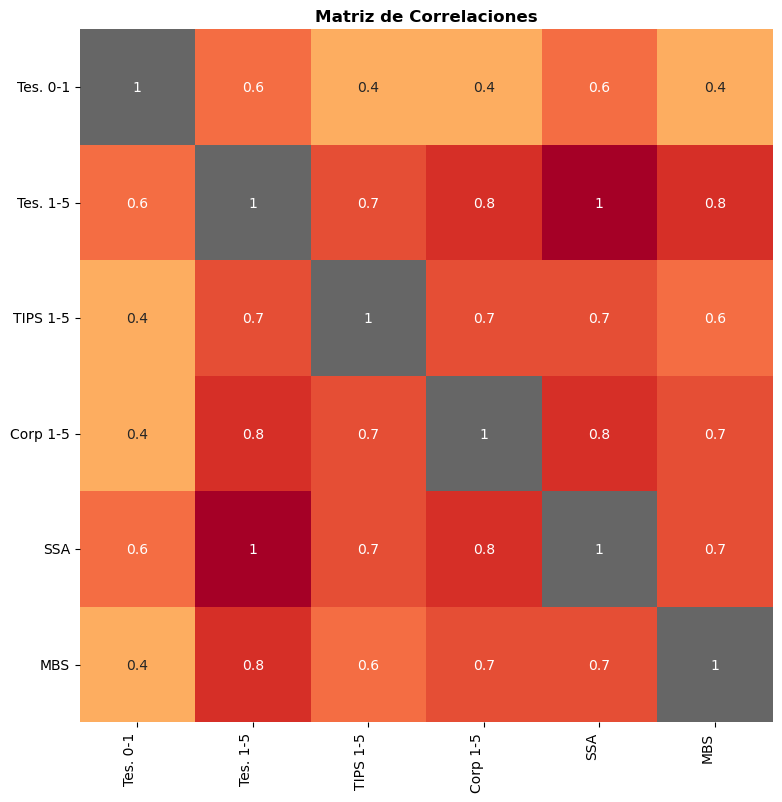

In [206]:
fig = heatmap(correlation_matrix)
plt.show()

Podemos entonces hacer la quasidiagonalización 

In [207]:
sort_ix = get_quasi_diag(linkage_matrix)
sort_ix 

[0, 2, 5, 3, 1, 4]

O directamente simplemente usar el orden del dendograma

In [208]:
correlation_matrix

,Tes. 0-1,Tes. 1-5,TIPS 1-5,Corp 1-5,SSA,MBS
Tes. 0-1,1.000000,0.633364,0.384323,0.405347,0.625509,0.374453
Tes. 1-5,0.633364,1.000000,0.662850,0.781974,0.972968,0.768063
TIPS 1-5,0.384323,0.662850,1.000000,0.658366,0.660166,0.582942
Corp 1-5,0.405347,0.781974,0.658366,1.000000,0.783886,0.697253
SSA,0.625509,0.972968,0.660166,0.783886,1.000000,0.744427
MBS,0.374453,0.768063,0.582942,0.697253,0.744427,1.000000


In [209]:
correlation_matrix_sorted = correlation_matrix.copy()
correlation_matrix_sorted = correlation_matrix_sorted.iloc[sort_ix,sort_ix] 
correlation_matrix_sorted

,Tes. 0-1,TIPS 1-5,MBS,Corp 1-5,Tes. 1-5,SSA
Tes. 0-1,1.000000,0.384323,0.374453,0.405347,0.633364,0.625509
TIPS 1-5,0.384323,1.000000,0.582942,0.658366,0.662850,0.660166
MBS,0.374453,0.582942,1.000000,0.697253,0.768063,0.744427
Corp 1-5,0.405347,0.658366,0.697253,1.000000,0.781974,0.783886
Tes. 1-5,0.633364,0.662850,0.768063,0.781974,1.000000,0.972968
SSA,0.625509,0.660166,0.744427,0.783886,0.972968,1.000000


In [210]:
# sorteamos la matriz de covarianzas que vamos a usar en el ejercicio demostrativo. 
cov_bp = cov_bp.iloc[sort_ix,sort_ix]
cov_bp.to_csv(os.path.join('Outputs\\'+'covariance_matrix.csv'), encoding = 'utf-8', sep = ';')

### 3. Bisección Recursiva

In [211]:
example_list = [0, 1, 2, 3, 4, 5, 6]
list[:int(len(example_list)/2)]
int(len(example_list)/2)

3

In [212]:
### Note que antes de llevar a cabo la bisección recursiva debemos escalar la matriz de covarianzas por 252. 
# cov = cov*252
weights = get_rec_bipart(cov, sort_ix)
weights

[]
[[0, 2, 5], [3, 1, 4]]
9.973082091598789e-06 0.00041740055163838694
0    0.976664
2    0.976664
5    0.976664
3    0.023336
1    0.023336
4    0.023336
dtype: float64
[]
[[0], [2, 5], [3], [1, 4]]
8.827382278340243e-06 0.0007544984224222986
0.0005959923498086296 0.00041360032352416316
0    0.965370
2    0.011295
5    0.011295
3    0.009560
1    0.013776
4    0.013776
dtype: float64
[]
[[2], [5], [1], [4]]
0.0007365476444108623 0.0014290805274684347
0.000436783269696468 0.00040340358720948285
0    0.965370
2    0.007453
5    0.003841
3    0.009560
1    0.006614
4    0.007162
dtype: float64
[]
[]
0    0.965370
2    0.007453
5    0.003841
3    0.009560
1    0.006614
4    0.007162
dtype: float64


C:\Users\jcamargo\AppData\Local\Temp\ipykernel_6888\2449221140.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.97666426 0.97666426 0.97666426]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[c_items0] *= alpha


0    0.965370
2    0.007453
5    0.003841
3    0.009560
1    0.006614
4    0.007162
dtype: float64

In [213]:
weights_HRP = pd.Series(data = weights)
shuffled_list = np.take([*diccionario_tickers.values()], sort_ix).tolist()
weights_HRP.index = shuffled_list
weights_HRP = weights_HRP.loc[[*diccionario_tickers.values()]] 
weights_HRP

Tes. 0-1    0.965370
Tes. 1-5    0.006614
TIPS 1-5    0.007453
Corp 1-5    0.009560
SSA         0.007162
MBS         0.003841
dtype: float64

In [214]:
### Podemos presentar los pesos finales de forma redondeada a un decimal.  
weights_HRP = weights_HRP*100
weights_HRP = weights_HRP.round(1)
weights_HRP


Tes. 0-1    96.5
Tes. 1-5     0.7
TIPS 1-5     0.7
Corp 1-5     1.0
SSA          0.7
MBS          0.4
dtype: float64

### Referencias

Hudson & Thames. (n.d.). The Hierarchical Risk Parity Algorithm: An Introduction. Retrieved February 12, 2025, from https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/